# Theoretical Foundations of Buffer Stock Saving

<cite data-cite="6202365/8AH9AXN2"></cite>

<p style="text-align: center;"><small><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></small></p>

[![econ-ark.org](https://img.shields.io/badge/Powered%20by-Econ--ARK-3e8acc.svg)](https://econ-ark.org/materials/BufferStockTheory)


<a id='interactive-dashboard'></a>

[This notebook](https://econ-ark.org/BufferStockTheory/#launch) uses the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit to reproduce and illustrate key results of the paper [Theoretical Foundations of Buffer Stock Saving](http://llorracc.github.io/BufferStockTheory/BufferStockTheory).

#### An [interactive dashboard](https://econ-ark.org/BufferStockStockTheory/#Dashboard) allows you to modify parameters to see how the figures change. 


In [1]:
# This cell does some standard python setup

# Import related generic python packages
import numpy as np
from copy import deepcopy

# Plotting tools
import matplotlib.pyplot as plt

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# Code to allow a master "Generator" and derived "Generated" versions
#   - allows "$nb-Problems-And-Solutions → $nb-Problems → $nb"
Generator=False # Is this notebook the master or is it generated?

# Whether to save the figures to Figures_dir
saveFigs=True

# Whether to draw the figures
drawFigs=True
required_hark_version = '0.10.8'

import HARK
if HARK.__version__ < required_hark_version:
    raise ImportError('This notebook requires at least econ-ark v',required_hark_version,' please update your installation pip install -U econ-ark or conda install -c conda-forge econ-ark')

from HARK.utilities import find_gui, make_figs, determine_platform, test_latex_installation, setup_latex_env_notebook

pf = determine_platform()
try:
    latexExists = test_latex_installation(pf)
except ImportError: # windows and MacOS requires manual install
    latexExists = False

setup_latex_env_notebook(pf, latexExists)

# check if GUI is present if not then switch drawFigs to False and force saveFigs to be True
if not find_gui():
    drawFigs = False
    saveFigs = True

# this can be removed if we pass in saveFigs and drawFigs in every call to make('figure')
def make(figure_name, target_dir="../../Figures"):
    make_figs(figure_name, saveFigs, drawFigs, target_dir)

In [2]:
# Import HARK tools
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs

## [The Problem](http://llorracc.github.io/BufferStockTheory/BufferStockTheory/#The-Problem)

The paper defines and calibrates a small set of parameters:

| Parameter | Description | Code | Value |
|:---:| ---         | ---  | :---: |
| $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\mathsf{R}$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\beta$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\rho$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\wp$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\theta^{\large u}$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\sigma_\psi$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\sigma_\theta$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

that define the preferences and environment of microeconomic consumers as detailed below. 

The objective of such a consumer with a horizon of $n$ periods is to maximize the value obtained from the stream of consumption __**c**__ from period $t=T-n$ to a terminal period $T$:

\begin{equation}
\mathbf{v}_{t} = \sum_{i=0}^{n} \beta^{n}\mathrm{u}(\mathbf{c}_{t+n}) 
\end{equation}

The infinite-horizon solution to the model is defined as the limit of the solution in the first period of life $\mathrm{c}_{T-n}$ as the horizon $n$ goes to infinity.

### Details
For a microeconomic consumer who begins period $t$ with __**m**__arket resources boldface $\mathbf{m}_{t}$ (=net worth plus current income), the amount that remains after __**c**__onsumption of $\mathbf{c}_{t}$ will be end-of-period __**a**__ssets $\mathbf{a}_{t}$, 

<!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $\mathbf{a}_{t}$ augmented by return factor $R$:-->

\begin{eqnarray}
\mathbf{a}_{t}   &=&\mathbf{m}_{t}-\mathbf{c}_{t}. \notag 
\end{eqnarray}

The consumer's __**p**__ermanent noncapital income $\mathbf{p}$ grows by a predictable factor $\Gamma$ and is subject to an unpredictable multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$,

\begin{eqnarray}
\mathbf{p}_{t+1} & = & \mathbf{p}_{t} \Gamma \psi_{t+1}, \notag 
\end{eqnarray}

and, if the consumer is employed, actual income is permanent income multiplied by a transitory shock $\theta^{\large e}$.  There is also a probability $\wp$ that the consumer will be temporarily unemployed and experience income of $\theta^{\large u}  = 0$.  We construct $\theta^{\large e}$ so that its mean value is $1/(1-\wp)$ because in that case the mean level of the transitory shock (accounting for both unemployed and employed states) is exactly 

\begin{eqnarray}
\mathbb{E}_{t}[\theta_{t+1}] & = & \theta^{\large{u}}  \times \wp + (1-\wp) \times \mathbb{E}_{t}[\theta^{\large{e}}_{t+1}] \notag
\\ & = & 0 \times \wp + (1-\wp) \times 1/(1-\wp)  \notag
\\ & = & 1. \notag
\end{eqnarray}

  We can combine the unemployment shock $\theta^{\large u}$ and the transitory shock to employment income $\theta^{\large e}$ into $\theta _{t+1}$, so that next period's market resources are
\begin{eqnarray}
    \mathbf{m}_{t+1} &=& \mathbf{a}_{t}\mathsf{R} +\mathbf{p}_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a CRRA utility function $u(\mathbf{c})=\frac{\mathbf{c}^{1-\rho}}{1-\rho}$, the paper shows that the problem can be written in terms of ratios (nonbold font) of level (bold font) variables to permanent income, e.g. $m_{t} \equiv \mathbf{m}_{t}/\mathbf{p}_{t}$, and the Bellman form of [the problem reduces to](https://llorracc.github.io/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& a_t \mathsf{R}/(\Gamma \psi_{t+1}) + \theta_{t+1} \\
\end{eqnarray*}

In [3]:
# Define a dictionary with baseline parameter values

# Import default parameter values (init_idiosyncratic_shock)
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks as base_params

# Set the parameters for the baseline results in the paper
# using the variable names defined in the cell above
base_params['PermGroFac'] =                [1.03] # Permanent income growth factor
base_params['Rfree']      = Rfree        =  1.04  # Interest factor on assets
base_params['DiscFac']    = DiscFac      =  0.96  # Time Preference Factor
base_params['CRRA']       = CRRA         =  2.00  # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb     =  0.005 # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp     =  0.0   # Induces natural borrowing constraint
base_params['PermShkStd'] =                 [0.1]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] =                 [0.1]   # Standard deviation of log transitory income shocks

In [4]:
# Uninteresting housekeeping and details
# Make global variables for the things that were lists above -- uninteresting housekeeping
PermGroFac, PermShkStd, TranShkStd = base_params['PermGroFac'][0],base_params['PermShkStd'][0],base_params['TranShkStd'][0]

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint

## Convergence of the Consumption Rules

Under the given parameter values, [the paper's first figure](https://llorracc.github.io/BufferStockTheory/#Convergence-of-the-Consumption-Rules) depicts the successive consumption rules that apply in the last period of life $(c_{T}(m))$, the second-to-last period, and earlier periods $(c_{T-n})$.  The consumption function to which these converge is $c(m)$:

$$
c(m) = \lim_{n \uparrow \infty} c_{T-n}(m) \notag
$$


In [5]:
# Create a buffer stock consumer instance by invoking the IndShockConsumerType class
# with the built-in parameter dictionary "base_params"

# Construct finite horizon agent with baseline parameters
baseAgent_Fin = IndShockConsumerType(**base_params)
baseAgent_Fin.cycles = 100   # Set finite horizon (T = 100)

baseAgent_Fin.solve()        # Solve the model
baseAgent_Fin.unpack('cFunc')  # Make the consumption function easily accessible

Saving figure cFuncsConverge in ../../Figures


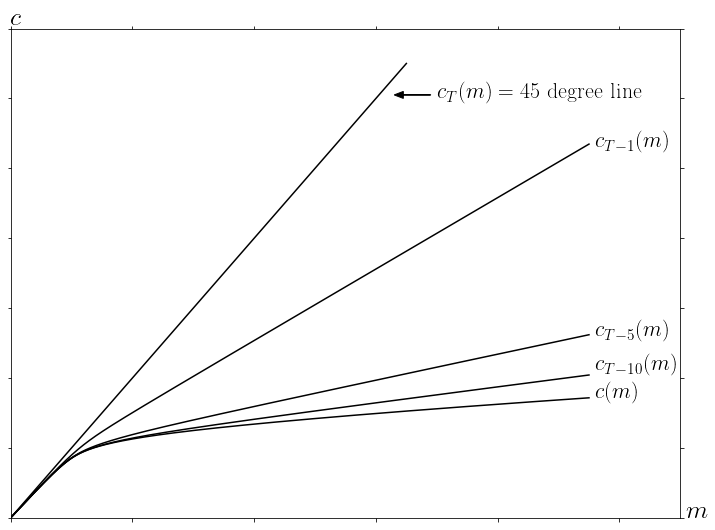

In [6]:
# Plot the different consumption rules for the different periods

mPlotMin  = 0
mLocCLabels = 9.6 # Defines horizontal limit of figure
mPlotTop = 6.5    # Defines maximum m value where functions are plotted
mPts  = 1000      # Number of points at which functions are evaluated

mBelwLabels    = np.linspace(mPlotMin,mLocCLabels-0.1,mPts) # Range of m below loc of labels
m_FullRange    = np.linspace(mPlotMin,mPlotTop,mPts)        # Full plot range 
c_Tm0  = m_FullRange                           # c_Tm0  defines the last period consumption rule (c=m)
c_Tm1  = baseAgent_Fin.cFunc[ -2](mBelwLabels) # c_Tm1 defines the second-to-last period consumption rule
c_Tm5  = baseAgent_Fin.cFunc[ -6](mBelwLabels) # c_Tm5 defines the T-5 period consumption rule
c_Tm10 = baseAgent_Fin.cFunc[-11](mBelwLabels) # c_Tm10 defines the T-10 period consumption rule
c_Limt = baseAgent_Fin.cFunc[  0](mBelwLabels) # c_Limt defines limiting inﬁnite-horizon consumption rule
plt.figure(figsize = (12,9))
plt.plot(mBelwLabels,c_Limt,color="black")
plt.plot(mBelwLabels,c_Tm1 ,color="black")
plt.plot(mBelwLabels,c_Tm5 ,color="black")
plt.plot(mBelwLabels,c_Tm10,color="black")
plt.plot(m_FullRange,c_Tm0 ,color="black")
plt.xlim(0,11)
plt.ylim(0,7)
plt.text(7.0,6.0,r'$c_{T   }(m) = 45$ degree line',fontsize = 22,fontweight='bold')
plt.text(mLocCLabels,5.3,r'$c_{T-1 }(m)$',fontsize = 22,fontweight='bold')
plt.text(mLocCLabels,2.6,r'$c_{T-5 }(m)$',fontsize = 22,fontweight='bold')
plt.text(mLocCLabels,2.1,r'$c_{T-10}(m)$',fontsize = 22,fontweight='bold')
plt.text(mLocCLabels,1.7,r'$c(m)       $',fontsize = 22,fontweight='bold')
plt.arrow(6.9,6.05,-0.6,0,head_width= 0.1,width=0.001,facecolor='black',length_includes_head='True')
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,7.05,"$c$",fontsize = 26)
plt.text(11.1,0,"$m$",fontsize = 26)
# Save the figures in several formats

make('cFuncsConverge') # Comment out if you want to run uninterrupted

Use the [interactive dashboard](#interactive-dashboard) to explore the effects of changes in patience, risk aversion, or risk

### PROBLEM: Natural Borrowing Constraint Approaches Artificial Constraint

Show numerically the result that is proven analytically in [The-Liquidity-Constrained-Solution-as-a-Limit](https://llorracc.github.io/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit), by solving the model for successively smaller values of $\wp$.
   * You need only to solve for the second-to-last period of life to do this
      * `TwoPeriodModel = IndShockConsumerType(**base_params)`
      * `TwoPeriodModel.cycles = 2   # Make this type have a two period horizon (Set T = 2)`

   * You should show the consumption rules for different values of $\wp$ on the same graph
      * To make this easier, you will want to use the plotFuncs command:
         * `from HARK.utilities import plotFuncsDer, plotFuncs`

Create a cell or cells in the notebook below this cell and put your solution there; comment on the size of $\wp$ needed to make the two models visually indistinguishable

## Factors and Conditions

### [The Finite Human Wealth Condition](http://llorracc.github.io/BufferStockTheory/#Human-Wealth)

Human wealth for a perfect foresight consumer is the present discounted value of future income:

\begin{eqnarray}\notag
\mathbf{h}_{t} & = & \mathbb{E}_{t}[\mathbf{p}_{t} + \mathsf{R}^{-1} \mathbf{p}_{t+1} + \mathsf{R}^{2} \mathbf{p}_{t+2} ... ] \\ \notag 
      & = & \mathbf{p}_{t} \left(1 + (\Gamma/\mathsf{R}) + (\Gamma/\mathsf{R})^{2} ... \right) 
\end{eqnarray}
which approaches infinity as the horizon extends if $\Gamma/\mathsf{R} \geq 1$.  We say that the 'Finite Human Wealth Condition' [(FHWC)](https://llorracc.github.io/BufferStockTheory/#FHWC) holds if
$0 \leq (\Gamma/\mathsf{R}) < 1$.

### [Absolute Patience and the AIC](https://llorracc.github.io/BufferStockTheory/#AIC)

The paper defines the Absolute Patience Factor [(APF)](https://llorracc.github.io/BufferStockTheory/#APF) as being equal to the ratio $\mathbf{c}_{t+1}/\mathbf{c}_{t}$ for a perfect foresight consumer.  The Old English character <span style="font-size:larger;">"&#222;"</span> used for this object in the paper cannot currently be rendered conveniently in Jupyter notebooks, so we will substitute $\Phi$ here:

\begin{equation}
\Phi = (\mathsf{R} \beta)^{1/\rho}
\end{equation}

If $\Phi = 1$, a perfect foresight consumer will spend at exactly the level of $\mathbf{c}$ that can be sustained perpetually (given their current and future resources).  If $\Phi < 1$ (the consumer is 'absolutely impatient'; or, 'the absolute impatience condition holds'), the consumer is consuming more than the sustainable amount, so consumption will fall, and if the consumer is 'absolutely patient' with $\Phi > 1$ consumption will grow over time.



### [Growth Patience and the GIC](https://llorracc.github.io/BufferStockTheory/#GIC)

For a [perfect foresight consumer](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA), whether the ratio $c$=__**c**__/__**p**__ is rising, constant, or falling depends on the relative growth rates of consumption and permanent income; that ratio is measured by the [Perfect Foresight Growth Patience Factor](https://llorracc.github.io/BufferStockTheory/#PFGPF):

\begin{eqnarray}
\Phi_{\Gamma} & = & \Phi/\Gamma
\end{eqnarray}
and whether the $c$ is falling or rising over time depends on whether $\Phi_{\Gamma}$ is below or above 1.

An analogous condition can be defined when there is uncertainty about permanent income.  Defining $\tilde{\Gamma} = (\mathbb{E}[\psi^{-1}])^{-1}\Gamma$, the 'Growth Impatience Condition' [(GIC)](https://llorracc.github.io/BufferStockTheory/#GIC) determines whether, \textit{in expectation}, the stochastic value of $c$ is rising, constant, or falling over time:
\begin{eqnarray}
  \Phi/\tilde{\Gamma} & < & 1
\end{eqnarray}

### [The Finite Value of Autarky Condition (FVAC)](https://llorracc.github.io/BufferStockTheory/#Autarky-Value)

The paper [shows](https://llorracc.github.io/BufferStockTheory/#Autarky-Value) that a consumer who planned to spend his permanent income $\{ \mathbf{p}_{t}, \mathbf{p}_{t+1}, ...\} $ in every period would have value defined by

\begin{equation*}
\mathbf{v}_{t}^{\text{autarky}} = u(\mathbf{p}_{t})\left(\frac{1}{1-\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}]}\right)
\end{equation*}

and defines the 'Finite Value of Autarky Condition' as the requirement that the denominator be a positive finite number:

\begin{equation*}
\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}] < 1
\end{equation*}

### [The Weak Return Impatience Condition (WRIC)](https://llorracc.github.io/BufferStockTheory/#WRIC)

The [Return Impatience Condition](https://llorracc.github.io/BufferStockTheory/#RIC) $\Phi/\mathsf{R} < 1$ has long been understood to be required for the perfect foresight model to have a nondegenerate solution (a common special case is when $\rho=1$; in this case $\Phi = \mathsf{R} \beta$ so $\Phi<1$ reduces to $\beta < \mathsf{R}$).  

If the RIC does not hold, the consumer is so patient that the optimal consumption function approaches zero as the horizon extends indefinitely.

When the probability of unemployment is $\wp$, the paper articulates an analogous (but weaker) condition:

\begin{eqnarray}
 \wp^{1/\rho} \Phi/\mathsf{R} & < & 1
\end{eqnarray}

# Key Results

## [Nondegenerate Solution Requires FVAC and WRIC](https://llorracc.github.io/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution)

A main result of the paper is that the conditions required for the model to have a nondegenerate solution ($0 < c(m) < \infty$ for feasible $m$) are that the Finite Value of Autarky (FVAC) and Weak Return Impatience Condition (WRIC) hold.

## [Natural Borrowing Constraint limits to Artificial Borrowing Constraint](https://llorracc.github.io/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit)

Defining $\chi(\wp)$ as the consumption function associated with any particular value of $\wp$, and defining $\hat{\chi}$ as the consumption function that would apply in the absence of the zero-income shocks but in the presence of an 'artificial' borrowing constraint requiring $a \geq 0$ (_a la_ Deaton (1991)), the paper shows that

\begin{eqnarray}
\lim_{\wp \downarrow 0}~\chi(\wp) & = & \hat{\chi}
\end{eqnarray}

That is, as $\wp$ approaches zero the problem with uncertainty becomes identical to the problem that instead has constraints.  (See [Precautionary Saving and Liquidity Constraints](https://llorracc.github.io/LiqConstr) for a full treatment of the relationship between precautionary saving and liquidity constraints).

## [$c(m)$ can be Finite Even When Human Wealth Is Infinite](https://llorracc.github.io/BufferStockTheory/#When-The-GIC-Fails)

In the perfect foresight model, if $\mathsf{R} < \Gamma$ the PDV of future labor income approaches infinity and so the limiting consumption function is $c(m) = \infty$ for all $m$.  Many models have no well-defined solution when human wealth is infinite.

The presence of uncertainty changes this: Even when limiting human wealth is infinite, the limiting consumption function is finite for all values of $m$.

This is because uncertainty imposes a "natural borrowing constraint" that deters the consumer from borrowing against their unbounded (but uncertain) future labor income.

A [table](https://llorracc.github.io/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution) puts this result in the context of implications of other conditions and restrictions.



## [If the GIC-Nrm Holds, $\exists$ a finite 'target' $m$](https://llorracc.github.io/BufferStockTheory/#onetarget)

Section [There Is Exactly One Target $m$ Ratio, Which Is Stable](https://llorracc.github.io/BufferStockTheory/#onetarget) shows that, under parameter values for which the limiting consumption function exists, if the GIC-Nrm holds then there will be a value $\check{m}$ such that:

\begin{eqnarray*}
\mathbb{E}[m_{t+1}] & > & m_{t}~\text{if $m_{t} < \check{m}$} \\
\mathbb{E}[m_{t+1}] & < & m_{t}~\text{if $m_{t} > \check{m}$} \\
\mathbb{E}[m_{t+1}] & = & m_{t}~\text{if $m_{t} = \check{m}$}
\end{eqnarray*}

Define 

\begin{align*}
\tilde{\psi} & = (\mathbb{E}_{t}[\psi_{t+1}^{-1}])^{-1}
\\ \tilde{\Gamma} & = \Gamma \tilde{\psi}
\end{align*}

and note that $\tilde{\psi} < 1$

We can solve for this value implicitly:
\begin{align*}
\mathbb{E}[m_{t+1}] & = (\mathsf{R}/\tilde{\Gamma}) (m_{t}-c(m_{t}))+1
\\ \check{m} & = (\mathsf{R}/\tilde{\Gamma}) (\check{m}-c(\check{m}))+1
\\ \check{m} - 1 & = (\mathsf{R}/\tilde{\Gamma}) (\check{m}-c(\check{m}))
\\ (\check{m} - 1)(\tilde{\Gamma}/\mathsf{R})  & = \check{m}-c(\check{m})
\\  c(\check{m}) & = \check{m}-(\check{m} - 1)(\tilde{\Gamma}/\mathsf{R})
\\  c(\check{m}) & = \check{m}(1-(\tilde{\Gamma}/\mathsf{R})) +(\tilde{\Gamma}/\mathsf{R})
\end{align*}
or find it more simply using the fact that the slope is monotonic and continuous so we can differentiate:
\begin{align*}
\\  c^{\prime}(\check{m}) & = (1-(\tilde{\Gamma}/\mathsf{R}))
\end{align*}


Expression in `addSSmNrm` code:
\begin{align*}
  = (1 - \Gamma/\mathsf{R}) m + (\Gamma/R)
\end{align*}


## Unique and Stable `Target` Ratios

(first part is same as before)

The paper examines a second special value of $m$ that defines a somewhat different kind of target.

$\hat{m}$ is defined as a value of $m$ at which the consumer expects `balanced growth` in their market resources and their permanent income:

\begin{align}
\mathbb{E}_{t}[\mathbf{m}_{t+1}]/\mathbf{m}_{t} & = \mathbb{E}_{t}[\mathbf{p}_{t+1}/\mathbf{p}_{t}]
\\ \mathbb{E}_{t}[{m}_{t+1}\mathbf{p}_{t+1}]/m_{t}\mathbf{p}_{t} & = \mathbb{E}_{t}[\Gamma\mathbf{p}_{t}\psi_{t+1}/\mathbf{p}_{t}]
\\ \mathbb{E}_{t}[{m}_{t+1}\Gamma \psi_{t+1}]/m_{t} & = \Gamma
\\ \mathbb{E}_{t}[{m}_{t+1} \psi_{t+1}] & = m_{t}
\end{align}

But
\begin{align}
\mathbb{E}[m_{t+1}] & =\mathbb{E}\left[\psi_{t+1}\left((\mathsf{R}/\Gamma \psi_{t+1}) (m_{t}-c(m_{t}))+\theta_{t+1}\right)\right]
\\ & =\mathbb{E}\left[\left((\mathsf{R}/\Gamma) (m_{t}-c(m_{t}))+\psi_{t+1}\theta_{t+1}\right)\right]
\\ & =(\mathsf{R}/\Gamma) (m_{t}-c(m_{t}))+1
\end{align}

And the target will be
\begin{align}
\hat{m} & =(\mathsf{R}/\Gamma) (\hat{m}-c(\hat{m}))+1
\\ \hat{m}-1 & =(\mathsf{R}/\Gamma) (\hat{m}-c(\hat{m}))
\\ (\Gamma/\mathsf{R})(\hat{m}-1) & =\hat{m}-c(\hat{m})
\\ c(\hat{m}) & = \hat{m}(1-(\Gamma/\mathsf{R})) +(\Gamma/\mathsf{R})
\end{align}


## [If the GIC Fails, Target Wealth is Infinite ](https://llorracc.github.io/BufferStockTheory/#The-GIC)

[A figure](https://llorracc.github.io/BufferStockTheory/#FVACnotGIC) depicts a solution when the **FVAC** (Finite Value of Autarky Condition) and **WRIC** hold (so that the model has a solution) but the **GIC** (Growth Impatience Condition) fails.  In this case the target wealth ratio is infinity.

The parameter values in this specific example are:

| Param | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.00 |
| $\mathrm{\mathsf{R}}$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |


In [8]:
# Construct the "GIC fails" example.

GIC_fails_dictionary = dict(base_params)
GIC_fails_dictionary['Rfree']      = 1.04
GIC_fails_dictionary['PermGroFac'] = [1.00]

GICFailsExample = IndShockConsumerType(
    cycles=0, # cycles=0 makes this an infinite horizon consumer
    verbose=0, # by default, check conditions shouldn't print out any information
    **GIC_fails_dictionary)

The $\mathtt{IndShockConsumerType}$ tool automatically checks various parametric conditions, and will give a warning as well as the values of the factors if key conditions fail to be met.

We can also directly check the conditions, asking for the maximum verbosity:

In [9]:
# The checkConditions method does what it sounds like it would
# verbose=0: Print nothing;
# verbose=3: Print all available info
GICFailsExample.checkConditions(verbose=3)


The given parameter values violate the Individual Growth Impatience Condition; the GPFInd is: 1.0085754579497024
 Therefore, a target ratio of individual market resources to individual permanent income does not exist.  (see https://llorracc.github.io/BufferStockTheory/#onetarget for more).


The value of the Aggregate Growth Patience Factor for the supplied parameter values satisfies the Aggregate Growth Impatience Condition; the value of the GPFAgg is: 0.9991996797437437
  Therefore, a target level of the ratio of aggregate market resources to aggregate permanent income exists.


The Weak Return Patience Factor value for the supplied parameter values satisfies the Weak Return Impatience Condition; the WRPF is 0.06793662204867575.
  Therefore, a nondegenerate solution exists if the FVAC is also satisfied.  (see https://llorracc.github.io/BufferStockTheory/#WRIC for more) 


The Finite Value of Autarky Factor (FVAV) for the supplied parameter values satisfies the Finite Value of Autark

### The Sustainable Level of Consumption

Next we define the $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]=0$ locus that shows the ‘sustainable’ level of spending at which $m$ is expected to remain unchanged.

In [10]:
# Calculate "Sustainable" consumption that leaves expected m unchanged
# In the perfect foresight case, this is just permanent income plus interest income
# A small adjustment is required to take account of the consequences of uncertainty
# See "Growth Patience and the GIC" above

# Get calibrated parameters to make code more readable
LivPrb=baseAgent_Fin.LivPrb[0]
Rfree=baseAgent_Fin.Rfree
DiscFac=baseAgent_Fin.DiscFac
CRRA=baseAgent_Fin.CRRA

permShkPrbs=GICFailsExample.PermShkDstn[0].pmf
permShkVals=GICFailsExample.PermShkDstn[0].X
EPermGroFac=GICFailsExample.PermGroFac[0]

# np.dot multiplies vectors; probability times value for each outcome is expectation
EpermShkInv   = np.dot(permShkPrbs, permShkVals**(-1))    # $   \mathbb{E}[\psi^{-1}]      $
InvEpermShkInv= (EpermShkInv) ** (-1)                     # $  (\mathbb{E}[\psi^{-1}])^{-1}$
PermGroFac    = EPermGroFac * InvEpermShkInv               # Uncertainty-adjusted permanent growth factor
ERNrmFac      = Rfree / PermGroFac                        # Interest factor normalized by uncertainty-adjusted growth
ErNrmRte      = ERNrmFac - 1                              # Interest rate is interest factor - 1
# "sustainable" C = P + (discounted) interest income
# "sustainable" c = 1 + (discounted, normalized) interest income
EmDelEq0      = lambda m : 1 + (m-1)*(ErNrmRte/ERNrmFac)  # "sustainable" c where E[Δ m] = 0

Saving figure FVACnotGIC in ../../Figures


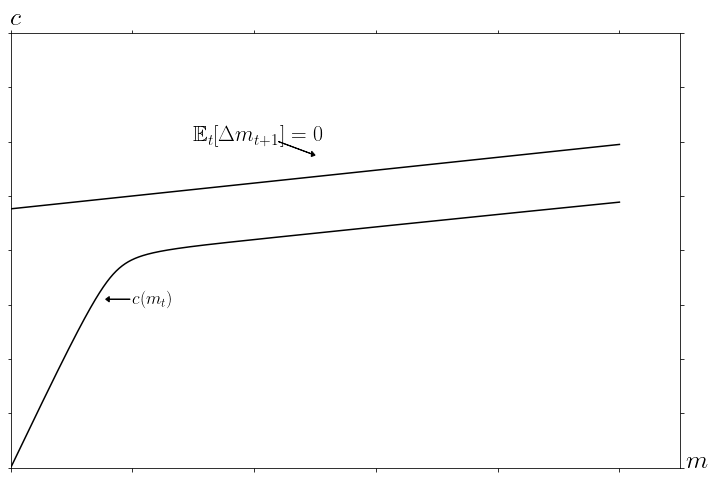

In [11]:
# Plot GICFailsExample consumption function against the sustainable level of consumption

GICFailsExample.solve()        # Above, we set up the problem but did not solve it
GICFailsExample.unpack('cFunc')  # Make the consumption function easily accessible for plotting
m = np.linspace(mPlotMin,5,mPts)
c_Limt = GICFailsExample.cFunc[0](m)
c_Sstn = EmDelEq0(m) # "sustainable" consumption
plt.figure(figsize = (12,8))
plt.plot(m,c_Limt,color="black")
plt.plot(m,c_Sstn,color="black")
plt.xlim(0,5.5)
plt.ylim(0,1.6)
plt.text(0,1.63,"$c$",fontsize = 26)
plt.text(5.55,0,"$m$",fontsize = 26)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(1,0.6,"$c(m_{t})$",fontsize = 18)
if latexExists:
    plt.text(1.5,1.2,"$\mathbb{E}_{t}[\Delta m_{t+1}] = 0$",fontsize = 22)
else:
    plt.text(1.5,1.2,"$\mathsf{E}_{t}[\Delta m_{t+1}] = 0$",fontsize = 22)

plt.arrow(0.98,0.62,-0.2,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.2,1.2,0.3,-0.05,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

make('FVACnotGIC') # Save figures (if appropriate/possible)

In the [interactive dashboard](#interactive-dashboard), see what happens as changes in the time preference rate (or changes in risk $\sigma_\Psi$) change the consumer from _growth-patient_ $(\Phi > \tilde{\Gamma})$ to _growth-impatient_ ($\Phi < \tilde{\Gamma}$)

In [12]:
GICFailsExample.PermGroFac

[1.0]

In [13]:
# Conditions can also be checked without solving the model
# verbose=0: Print nothing
# verbose=3: Print all available results
GICFailsExample.checkConditions(verbose=3)  


The given parameter values violate the Individual Growth Impatience Condition; the GPFInd is: 1.0085754579497024
 Therefore, a target ratio of individual market resources to individual permanent income does not exist.  (see https://llorracc.github.io/BufferStockTheory/#onetarget for more).


The value of the Aggregate Growth Patience Factor for the supplied parameter values satisfies the Aggregate Growth Impatience Condition; the value of the GPFAgg is: 0.9991996797437437
  Therefore, a target level of the ratio of aggregate market resources to aggregate permanent income exists.


The Weak Return Patience Factor value for the supplied parameter values satisfies the Weak Return Impatience Condition; the WRPF is 0.06793662204867575.
  Therefore, a nondegenerate solution exists if the FVAC is also satisfied.  (see https://llorracc.github.io/BufferStockTheory/#WRIC for more) 


The Finite Value of Autarky Factor (FVAV) for the supplied parameter values satisfies the Finite Value of Autark

As a foundation for the remaining figures, we define another instance of the class $\texttt{IndShockConsumerType}$, which has the same parameter values as the instance $\texttt{baseAgent}$ defined previously but is solved to convergence (our definition of an infinite horizon agent type) instead of only 100 periods


In [14]:
# cycles=0 tells the solver to find the infinite horizon solution
baseAgent_Inf = IndShockConsumerType(cycles=0,verbose=0, **base_params)

baseAgent_Inf.solve()
baseAgent_Inf.unpack('cFunc')

### [Target $m$, Expected Consumption Growth, and Permanent Income Growth](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisoftheConvergedConsumptionFunction)

The next figure, [Analysis of the Converged Consumption Function](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cGroTargetFig), shows the expected consumption growth factor $\mathrm{\mathbb{E}}_{t}[\mathbf{c}_{t+1}/\mathbf{c}_{t}]$ for a consumer behaving according to the converged consumption rule.

Conveniently, this can be computed without knowing the _level_ of the consumer's income:

\begin{eqnarray}
\mathbb{E}_{t}[\mathbf{c}_{t+1}/\mathbf{c}_{t}] & = & \mathbb{E}_{t}\left[\frac{\mathbf{p}_{t+1}c_{t+1}(m_{t+1})}{\mathbf{p}_{t}c_{t}(m_{t})}\right] \\ 
& = & \mathbb{E}_{t}\left[\frac{\Gamma \psi_{t+1} \mathbf{p}_{t}}{\mathbf{p}_{t}}\frac{c_{t+1}(m_{t+1})}{c_{t}(m_{t})}\right] \\
& = & \mathbb{E}_{t}\left[\frac{\Gamma \psi_{t+1} c_{t+1}(m_{t+1})}{c_{t}(m_{t})}\right] 
\end{eqnarray}


In [15]:
# Def a function to calc ratio of cLev_{t+1} to p_{t}
def EcLev_tp1_Over_p_t(a):
    '''
    Taking end-of-period assets a as input, return ratio of expectation 
    of next period's consumption to this period's permanent income 

    Inputs:
       a: end-of-period assets
    Returns:
       EcLev_tp1_Over_p_{t}: next period's expected c level / current p
    '''
    # Extract parameter values to make code more readable
    permShkVals=baseAgent_Inf.PermShkDstn[0].X
    tranShkVals=baseAgent_Inf.TranShkDstn[0].X
    permShkPrbs=baseAgent_Inf.PermShkDstn[0].pmf
    tranShkPrbs=baseAgent_Inf.TranShkDstn[0].pmf
    Rfree      =baseAgent_Inf.Rfree
    EPermGroFac=baseAgent_Inf.PermGroFac[0]
    
    PermGrowFac_tp1 = EPermGroFac*permShkVals # Nonstochastic growth times idiosyncratic permShk
    RNrmFac_tp1     = Rfree / PermGrowFac_tp1 # Growth-normalized interest factor 
    # 'bank balances' b = end-of-last-period assets times normalized return factor
    b_tp1 = RNrmFac_tp1*a
    # expand dims of b_tp1 and use broadcasted sum of a column and a row vector
    # to obtain a matrix of possible market resources next period
    # because matrix mult is much much faster than looping to calc E
    m_tp1_GivenTranAndPermShks = np.expand_dims(b_tp1, axis=1) + tranShkVals
    # List of possible values of $\mathbf{c}_{t+1}$ (Transposed by .T)
    cRat_tp1_GivenTranAndPermShks = baseAgent_Inf.cFunc[0](m_tp1_GivenTranAndPermShks).T
    cLev_tp1_GivenTranAndPermShks = cRat_tp1_GivenTranAndPermShks*PermGrowFac_tp1
    # compute expectation over perm shocks by right multiplying with probs
    EOverPShks_cLev_tp1_GivenTranShkShks = np.dot(cLev_tp1_GivenTranAndPermShks, permShkPrbs)
    # finish expectation over trans shocks by right multiplying with probs
    EcLev_tp1_Over_p_t = np.dot(EOverPShks_cLev_tp1_GivenTranShkShks, tranShkPrbs)
    # return expected consumption
    return EcLev_tp1_Over_p_t

In [16]:
# Calculate the expected consumption growth factor
# mBelwTrg defines the plot range on the left of target m value (e.g. m <= target m)
mNrmTrg=baseAgent_Inf.solution[0].mNrmSS
mBelwTrg = np.linspace(1,mNrmTrg,50) 
c_For_mBelwTrg = baseAgent_Inf.cFunc[0](mBelwTrg)
a_For_mBelwTrg = mBelwTrg-c_For_mBelwTrg
EcLev_tp1_Over_p_t_For_mBelwTrg = [EcLev_tp1_Over_p_t(i) for i in a_For_mBelwTrg]

# mAbveTrg defines the plot range on the right of target m value (e.g. m >= target m)
mAbveTrg = np.linspace(mNrmTrg,1.9,50)

# EcGro_For_mAbveTrg: E [consumption growth factor] when m_{t} is below target m
EcGro_For_mBelwTrg = np.array(EcLev_tp1_Over_p_t_For_mBelwTrg)/c_For_mBelwTrg

c_For_mAbveTrg = baseAgent_Inf.cFunc[0](mAbveTrg)
a_For_mAbveTrg = mAbveTrg-c_For_mAbveTrg
EcLev_tp1_Over_p_t_For_mAbveTrg = [EcLev_tp1_Over_p_t(i) for i in a_For_mAbveTrg]

# EcGro_For_mAbveTrg: E [consumption growth factor] when m_{t} is bigger than target m_{t}
EcGro_For_mAbveTrg = np.array(EcLev_tp1_Over_p_t_For_mAbveTrg)/c_For_mAbveTrg 

In [17]:
# Define a function to construct the arrows on the consumption growth rate function
def arrowplot(axes, x, y, narrs=15, dspace=0.5, direc='neg',
              hl=0.01, hw=3, c='black'):
    '''
    The function is used to plot arrows given the data x and y.

    Input:
        narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head

        hw     :  width of the arrow head

        c      :  color of the edge and face of the arrow head
    '''

    # r is the distance spanned between pairs of points
    r = np.sqrt(np.diff(x)**2+np.diff(y)**2)
    r = np.insert(r, 0, 0.0)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = np.cumsum(r)

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace)
    else:
        dspace = abs(dspace)

    arrowData = list() # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]:
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2.0 + ax
        dy0 = np.cos(theta)*hl/2.0 + ay
        dx1 = -1.*np.sin(theta)*hl/2.0 + ax
        dy1 = -1.*np.cos(theta)*hl/2.0 + ay

        if direc is 'neg' :
            ax0 = dx0
            ay0 = dy0
            ax1 = dx1
            ay1 = dy1
        else:
            ax0 = dx1
            ay0 = dy1
            ax1 = dx0
            ay1 = dy0

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=c, fc=c))

Saving figure cGroTargetFig in ../../Figures


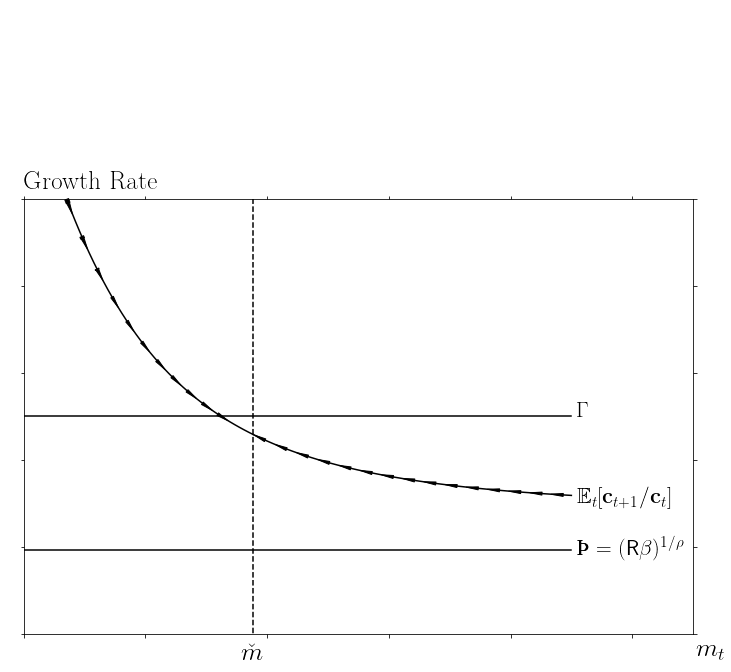

In [18]:
# Plot consumption growth as a function of market resources

# Retrieve parameters (makes code readable)
Rfree      = baseAgent_Inf.Rfree
DiscFac    = baseAgent_Inf.DiscFac
CRRA       = baseAgent_Inf.CRRA
EPermGroFac= baseAgent_Inf.PermGroFac[0]
mNrmTrg    = baseAgent_Inf.solution[0].mNrmSS

# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
APF = (Rfree*DiscFac)**(1.0/CRRA)

fig = plt.figure(figsize = (12,8))
ax  = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[APF,APF],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[EPermGroFac,EPermGroFac],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(mBelwTrg,EcGro_For_mBelwTrg,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(mAbveTrg,EcGro_For_mAbveTrg,color="black")

# Plot the arrows
arrowplot(ax, mBelwTrg,EcGro_For_mBelwTrg)
arrowplot(ax, mAbveTrg,EcGro_For_mAbveTrg, direc='pos')
fsbig=26
fsmid=22

# Plot the target m
ax.plot([mNrmTrg,mNrmTrg],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.10)
ax.set_ylim(0.98,1.08)
ax.text(1,1.082,r'$\text{Growth Rate}$',fontsize = fsbig,fontweight='bold')
ax.text(2.105,0.975,"$m_{t}$",fontsize = fsbig,fontweight='bold')
if latexExists:
    ax.text(1.91,1.01,"$\mathbb{E}_{t}[\mathbf{c}_{t+1}/\mathbf{c}_{t}]$",fontsize = fsmid,fontweight='bold')
else:
    ax.text(1.91,1.01,"$\mathsf{E}_{t}[\mathbf{c}_{t+1}/\mathbf{c}_{t}]$",fontsize = fsmid,fontweight='bold')
ax.text(mNrmTrg-0.02,0.974, r'$\check{m}$', fontsize = fsbig,fontweight='bold')
ax.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
if latexExists:
    ax.text(1.91,0.998,r'$\pmb{\text{\TH}} = (\mathsf{R}\beta)^{1/\rho}$',fontsize = fsmid,fontweight='bold')
else:
    ax.text(1.91,0.998,r'$\Phi = (\mathsf{\mathsf{R}}\beta)^{1/\rho}$',fontsize = fsmid,fontweight='bold')

ax.text(1.91,1.03, r'$\Gamma$',fontsize = fsmid,fontweight='bold')
make('cGroTargetFig')

In the [interactive dashboard](#interactive-dashboard) see how target wealth changes when the consumer's time preference factor β or the growth factor Γ change.

### [Consumption Function Bounds](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisOfTheConvergedConsumptionFunction)
[The next figure](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)
illustrates theoretical bounds for the consumption function.

We define two useful variables: lower bound of $\kappa$ (marginal propensity to consume) and limit of $h$ (Human wealth), along with some functions such as the limiting perfect foresight consumption function $\bar{c}(m)$, the upper bound function $\bar{\bar c}(m)$, and the lower bound function \underline{_c_}$(m)$.

In [19]:
# Define κ_Min, h_inf and perfect foresight consumption function, upper bound of consumption function and lower
# bound of consumption function.

# Retrieve parameters (makes code readable)
Rfree      = baseAgent_Inf.Rfree
DiscFac    = baseAgent_Inf.DiscFac
CRRA       = baseAgent_Inf.CRRA
EPermGroFac= EPermGroFac
mNrmTrg    = baseAgent_Inf.solution[0].mNrmSS
UnempPrb   = baseAgent_Inf.UnempPrb

κ_Min = 1.0-(Rfree**(-1.0))*(Rfree*DiscFac)**(1.0/CRRA)
h_inf = (1.0/(1.0-EPermGroFac/Rfree))
cFunc_Uncnst = lambda m: (h_inf -1)* κ_Min + κ_Min*m
cFunc_TopBnd = lambda m: (1 - UnempPrb ** (1.0/CRRA)*(Rfree*DiscFac)**(1.0/CRRA)/Rfree)*m
cFunc_BotBnd = lambda m: (1 -(Rfree*DiscFac)**(1.0/CRRA)/Rfree) * m

Saving figure cFuncBounds in ../../Figures


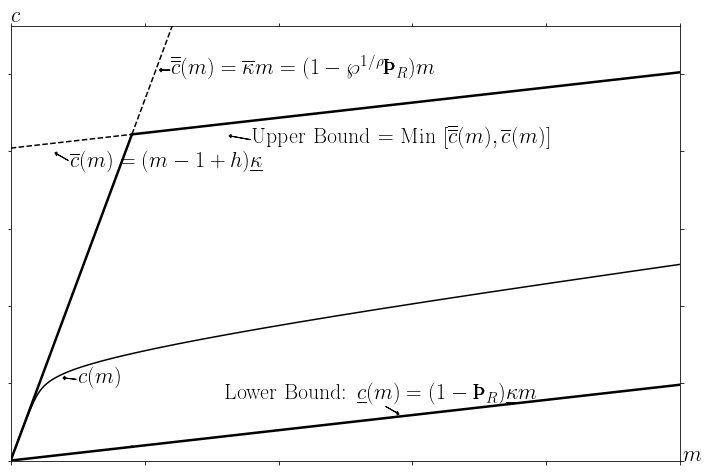

In [20]:
# Plot the consumption function and its bounds

cMaxLabel=r'$\overline{c}(m) = (m-1+h)\underline{\kappa}$'
cMinLabel=r'Lower Bound: $\underline{c}(m)= (1-\pmb{\text{\TH}}_{R})\underline{\kappa}m$'
if not latexExists:
    cMaxLabel=r'$\overline{c}(m) = (m-1+h)κ̲' # Use unicode kludge
    cMinLabel=r'Lower Bound: c̲$(m)= (1-\Phi_{R})m = κ̲ m$'

mPlotMax = 25
mPlotMin = 0
# mKnk is point where the two upper bounds meet
mKnk = ((h_inf-1)* κ_Min)/((1 - UnempPrb**(1.0/CRRA)*(Rfree*DiscFac)**(1.0/CRRA)/Rfree)-κ_Min)
mBelwKnkPts = 300
mAbveKnkPts = 700
mBelwKnk = np.linspace(mPlotMin,mKnk,mBelwKnkPts)
mAbveKnk = np.linspace(mKnk,mPlotMax,mAbveKnkPts)
mFullPts = np.linspace(mPlotMin,mPlotMax,mBelwKnkPts+mAbveKnkPts)

plt.figure(figsize = (12,8))
plt.plot(mFullPts,baseAgent_Inf.cFunc[0](mFullPts), color="black")
plt.plot(mBelwKnk,cFunc_Uncnst(mBelwKnk)          , color="black",linestyle="--")
plt.plot(mAbveKnk,cFunc_Uncnst(mAbveKnk)          , color="black",linewidth=2.5)
plt.plot(mBelwKnk,cFunc_TopBnd(mBelwKnk)          , color="black",linewidth=2.5)
plt.plot(mAbveKnk,cFunc_TopBnd(mAbveKnk)          , color="black",linestyle="--")
plt.plot(mBelwKnk,cFunc_BotBnd(mBelwKnk)          , color="black",linewidth=2.5)
plt.plot(mAbveKnk,cFunc_BotBnd(mAbveKnk)          , color="black",linewidth=2.5)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.xlim(mPlotMin,mPlotMax)
plt.ylim(mPlotMin,1.12*cFunc_Uncnst(mPlotMax))
plt.text(mPlotMin,1.12*cFunc_Uncnst(mPlotMax)+0.05,"$c$",fontsize = 22)
plt.text(mPlotMax+0.1,mPlotMin,"$m$",fontsize = 22)
plt.text(2.5,1,r'$c(m)$',fontsize = 22,fontweight='bold')
if latexExists:
    plt.text(6,5,r'$\overline{\overline{c}}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}\pmb{\text{\TH}}_{R})m$',fontsize = 22,fontweight='bold')
else:
    plt.text(6,5,r'$\overline{\overline{c}}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}\Phi_{R})m$',fontsize = 22,fontweight='bold')
plt.text(2.2,3.8, cMaxLabel,fontsize = 22,fontweight='bold')
plt.text(9,4.1,r'Upper Bound $ = $ Min $[\overline{\overline{c}}(m),\overline{c}(m)]$',fontsize = 22,fontweight='bold')
plt.text(8,0.8,cMinLabel,fontsize = 22,fontweight='bold')
plt.arrow(2.45,1.05,-0.5,0.02,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.15,3.88,-0.5,0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(8.95,4.15,-0.8,0.05,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,5.05,-0.4,mPlotMin,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(14,0.70,0.5,-0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')

make('cFuncBounds')

### [The Consumption Function and Target $m$](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)

This figure shows the $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]=0$ locus and consumption function $c(m_{t})$, along with the intersection of these two functions, which defines the target value of $m$

Saving figure cRatTargetFig in ../../Figures


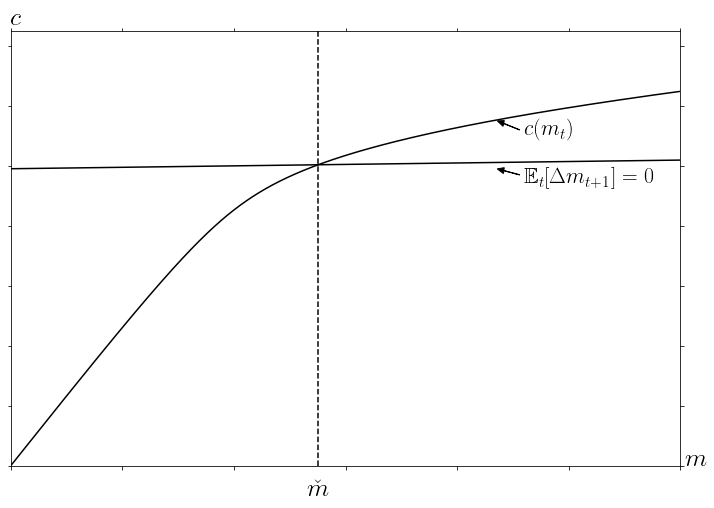

In [21]:
# This just plots objects that have already been constructed

mBelwTrg = np.linspace(mPlotMin,4,mPts)
EmDelEq0 = lambda m:(EPermGroFac/Rfree)+(1.0-EPermGroFac/Rfree)*m
cBelwTrg_Best = baseAgent_Inf.cFunc[0](mBelwTrg) # "best" = optimal c
cBelwTrg_Sstn = EmDelEq0(mBelwTrg)               # "sustainable" c
plt.figure(figsize = (12,8))
plt.plot(mBelwTrg,cBelwTrg_Best, color="black")
plt.plot(mBelwTrg,cBelwTrg_Sstn, color="black")
plt.xlim(mPlotMin,3)
plt.ylim(mPlotMin,1.45)
plt.plot([mNrmTrg, mNrmTrg],[mPlotMin,2.5],color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(mPlotMin,1.47,r"$c$",fontsize = 26)
plt.text(3.02,mPlotMin,r"$m$",fontsize = 26)
if latexExists:
    plt.text(2.3,0.94,r'$\mathbb{E}_{t}[\Delta m_{t+1}] = 0$',fontsize = 22,fontweight='bold')
else:
    plt.text(2.3,0.94,r'$\mathsf{E}_{t}[\Delta m_{t+1}] = 0$',fontsize = 22,fontweight='bold')
plt.text(2.3,1.1,r"$c(m_{t})$",fontsize = 22,fontweight='bold')
plt.text(mNrmTrg-0.05,-0.1, r"$\check{m}$",fontsize = 26)
plt.arrow(2.28,1.12,-0.1,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.28,0.97,-0.1,0.02,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

make('cRatTargetFig')

### [Upper and Lower Limits of the Marginal Propensity to Consume](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#MPCLimits)

The paper shows that as $m_{t}~\uparrow~\infty$ the consumption function in the presence of risk gets arbitrarily close to the perfect foresight consumption function.  Defining \underline{κ}
as the perfect foresight model's MPC, this implies that $\lim_{m_{t}~\uparrow~\infty} c^{\prime}(m) = $ \underline{κ}
.

The paper also derives an analytical limit $\bar{\kappa}$ for the MPC as $m$ approaches 0., its bounding value.  Strict concavity of the consumption function implies that the consumption function will be everywhere below a function $\bar{\kappa}m$, and strictly declining everywhere.  The last figure plots the MPC between these two limits.

Saving figure MPCLimits in ../../Figures


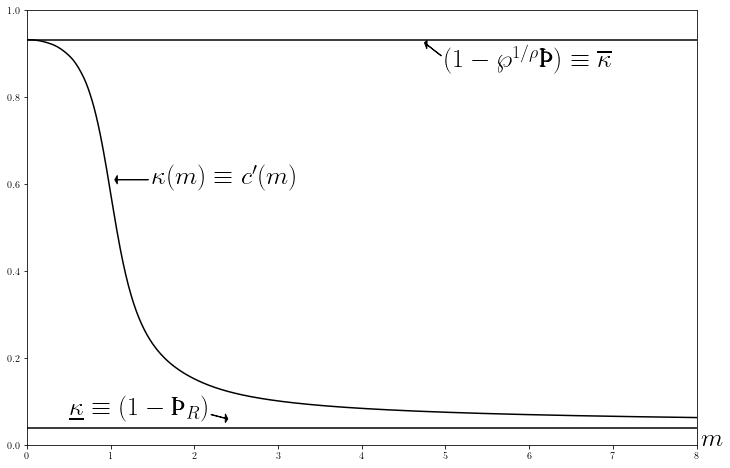

In [22]:
# The last figure shows the upper and lower limits of the MPC

# Retrieve parameters (makes code readable)
Rfree      = baseAgent_Inf.Rfree
DiscFac    = baseAgent_Inf.DiscFac
CRRA       = baseAgent_Inf.CRRA
EPermGroFac= EPermGroFac
mNrmTrg    = baseAgent_Inf.solution[0].mNrmSS
UnempPrb   = baseAgent_Inf.UnempPrb

mPlotMax=8    

plt.figure(figsize = (12,8))
# Set the plot range of m
m = np.linspace(0.001,mPlotMax,mPts)

# Use the HARK method derivative to get the derivative of cFunc, and which constitutes the MPC
MPC = baseAgent_Inf.cFunc[0].derivative(m)

# Define the upper bound of MPC
κ_Max = (1 - UnempPrb ** (1.0/CRRA)*(Rfree*DiscFac)**(1.0/CRRA)/Rfree)

# Define the lower bound of MPC
MPCLower = κ_Min

kappaDef=r'$\underline{\kappa}\equiv(1-\pmb{\text{\TH}}_{R})$'
if not latexExists:
    kappaDef=r'κ̲$\equiv(1-\Phi_{R})$'

plt.plot(m,MPC,color = 'black')
plt.plot([mPlotMin,mPlotMax],[κ_Max,κ_Max],color = 'black')
plt.plot([mPlotMin,mPlotMax],[κ_Min,κ_Min],color = 'black')
plt.xlim(mPlotMin,mPlotMax)
plt.ylim(0,1) # MPC bounds are between 0 and 1 
plt.text(1.5,0.6,r'$\kappa(m) \equiv c^{\prime}(m)$',fontsize = 26,fontweight='bold')
if latexExists:
    plt.text(5,0.87,r'$(1-\wp^{1/\rho}\pmb{\text{\TH}})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold') # Use Thorn character
else:
    plt.text(5,0.87,r'$(1-\wp^{1/\rho}\Phi_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold') # Use Phi instead of Thorn (alas)

plt.text(0.5,0.07,kappaDef,fontsize = 26,fontweight='bold')
plt.text(mPlotMax+0.05,mPlotMin,"$m$",fontsize = 26)
plt.arrow(1.45,0.61,-0.4,mPlotMin,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.2,0.07,0.2,-0.01,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(4.95,0.895,-0.2,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

make('MPCLimits')

# Summary

[Two tables in the paper](https://llorracc.github.io/BufferStockTheory/#Factors-Defined-And-Compared) summarize the various definitions, and then articulate conditions required for the problem to have a nondegenerate solution.  Among the nondegenerate cases, the most interesting result is that if the Growth Impatience Condition holds there will be a target level of wealth.

### Appendix: Options for Interacting With This Notebook <a id='optionsForInstalling'></a>

1. [View (static version)](https://github.com/llorracc/BufferStockTheory/blob/master/Code/Python/BufferStockTheory.ipynb) on GitHub (warning:  GitHub does not render Jupyter notebooks reliably)
1. [Launch Online Interactive Version](https://econ-ark.org/materials/BufferStockTheory/#launch)
1. For fast (local) execution, install [econ-ark](http://github.com/econ-ark) on your computer ([QUICK START GUIDE](https://github.com/econ-ark/HARK/blob/master/README.md)) then follow these instructions to retrieve the full contents of the `BufferStockTheory` [REMARK](https://github.com/econ-ark/REMARK):
   1. At a command line, change the working directory to the one where you want to install
       * On unix, if you install in the `/tmp` directory, the installation will disappear after a reboot:
       * `cd /tmp`
   1. `git clone https://github.com/econ-ark/REMARK --recursive`
   1. `cd REMARK/REMARKs/BufferStockTheory`
   1. `jupyter notebook BufferStockTheory.ipynb`

### Appendix: Perfect foresight agent failing both the FHWC and RIC

The value of the Absolute Patience Factor (APF) for the supplied parameter values satisfies the Absolute Impatience Condition.
  Because the APF < 1, the absolute amount of consumption is expected to fall over time.
The value of the Growth Patience Factor for the supplied parameter values satisfies the Perfect Foresight Growth Impatience Condition.
  Therefore, for a perfect foresight consumer, the ratio of individual wealth to permanent income will fall indefinitely.
The value of the Return Patience Factor for the supplied parameter values fails the Return Impatience Condition; the factor is 1.0101525445522108
  Therefore, if the FHWC is satisfied, the limiting consumption function is c(m)=0 for all m.
The given type violates the Finite Human Wealth Condition; the Finite Human wealth factor value is 1.010204081632653


Saving figure PFGICHoldsFHWCFailsRICFails in ../../Figures


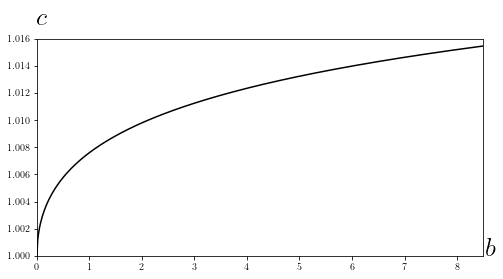

In [23]:
from copy import copy
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
fig6_par = copy(base_params)

# Replace parameters.
fig6_par['Rfree'] = 0.98
fig6_par['DiscFac'] = 1
fig6_par['PermGroFac'] = [0.99]
fig6_par['CRRA'] = 2
fig6_par['BoroCnstArt']  = 0
fig6_par['T_cycle'] = 0
fig6_par['cycles'] = 0
fig6_par['quiet'] = False

# Create the agent
RichButPatientAgent = PerfForesightConsumerType(**fig6_par)
# Check conditions
RichButPatientAgent.checkConditions(verbose = 3)
# Solve
RichButPatientAgent.solve()

# Plot
mPlotMin, mPlotMax = 1, 9.5
plt.figure(figsize = (8,4))
m_grid = np.linspace(mPlotMin,mPlotMax,500)
plt.plot(m_grid-1, RichButPatientAgent.solution[0].cFunc(m_grid), color="black")
plt.text(mPlotMax-1+0.05,1,r"$b$",fontsize = 26)
plt.text(mPlotMin-1,1.017,r"$c$",fontsize = 26)
plt.xlim(mPlotMin-1,mPlotMax-1)
plt.ylim(mPlotMin,1.016)

make('PFGICHoldsFHWCFailsRICFails')